# Predicting Cancer Malignancy with a 2 layer neural network coded from scratch in Python.


**This notebook holds the Python code connected to this 3 part article:**

**<a href="https://towardsdatascience.com/the-keys-of-deep-learning-in-100-lines-of-code-907398c76504" target="_blank">Part 1</a> | <a href="https://towardsdatascience.com/coding-a-2-layer-neural-network-from-scratch-in-python-4dd022d19fd2" target="_blank">Part 2</a> | <a href="https://medium.com/predicting-breast-cancer-tumors-with-your-own-neural-network-76271a05e941" target="_blank">Part 3</a>**<br>

**With this code and the associated articles, you are going to:**
- Create a neural network from scratch in Python. Train it using the gradient descent algorithm.
- Apply that basic network to The Wisconsin Cancer Data-set. Predict if a tumor is benign or malignant, based on 9 different features.
- Explore deeply how back-propagation and gradient descent work.
- Review the basics and explore advanced concepts. 





In [42]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from scipy.stats import truncnorm
from sklearn.model_selection import train_test_split
import itertools

**The Dlnet 2 layer neural network class**

A 2 layer neural network class with gradient descent in less than 100 lines of code

In [3]:
def ft_accuracy_score(y, y_pred):
    y = y.values
    y_pred = y_pred
    summa = 0.0
    m = len(y)
    for i in range(m):
        if y[i] == y_pred[i]:
            summa += 1
    return summa / m

In [27]:
class dlnet:
    def __init__(self, hidden_neurons1, hidden_neurons2, out_neurons, learning_rate=0.1):
        self.hidden_neurons1 = hidden_neurons1
        self.hidden_neurons2 = hidden_neurons2
        self.out_neurons = out_neurons

        self.param = {}
        self.cach = {}
        self.loss = []
        self.loss_valid = []
        self.lr = learning_rate

    def init_bias(self, n_neurons):
        b = np.zeros(n_neurons)
        return b.reshape(-1, 1)

    def init_weights(self, n_inputs, n_neurons):
        random_state = np.random.randint(1000)
        stddev = 2 / np.sqrt(n_inputs + n_neurons)
        weights = truncnorm.rvs(-1, 1, size=(n_neurons, n_inputs), scale=stddev, random_state=random_state)
        return weights

    def sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))

    def dsigmoid(self, Z):
        return Z * (1 - Z)
    
    def softmax(self, Z):
        return np.log(1 + np.exp(Z))
    
    def dsoftmax(self, Z):
        return np.exp(Z) / (1 + np.exp(Z))

    def init(self, m):
        self.param['W1'] = self.init_weights(m, self.hidden_neurons1)
        self.param['b1'] = self.init_bias(self.hidden_neurons1)
        self.param['W2'] = self.init_weights(self.hidden_neurons1, self.hidden_neurons2)
        self.param['b2'] = self.init_bias(self.hidden_neurons2)
        self.param['W3'] = self.init_weights(self.hidden_neurons2, self.out_neurons)
        self.param['b3'] = self.init_bias(self.out_neurons)
        pass

    def crossenthropy(self, y, y_pred):
        m = y.shape[1]
        return (-1.0 / m) * (y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))

    def feedforward(self, X, weights, bias, activation=None):
        V = np.dot(weights, X) + bias
        if activation is not None:
            F = activation(V)
        return V, F
    
    def forward(self, X, y, activation=None):
        v1, f1 = self.feedforward(X, self.param['W1'], self.param['b1'], self.sigmoid)
        v2, f2 = self.feedforward(f1, self.param['W2'], self.param['b2'], self.sigmoid)
        v3, f3 = self.feedforward(f2, self.param['W3'], self.param['b3'], self.sigmoid)
        y_pred = f3

        self.cach['v1'] = v1
        self.cach['f1'] = f1
        self.cach['v2'] = v2
        self.cach['f2'] = f2
        self.cach['v3'] = v3
        self.cach['f3'] = f3

        loss = self.crossenthropy(y, y_pred)
        
        return y_pred, loss
    
    def backpropagation(self, X, y, y_pred):
        derror = -(np.divide(y, y_pred) - np.divide(1 - y, 1 - y_pred))

        local_grad1 = derror * self.dsigmoid(y_pred)
        grad_w3 = 1.0 / self.cach['f2'].shape[1] * np.dot(local_grad1, self.cach['f2'].T)
        grad_b3 = 1.0 / self.cach['f2'].shape[1] * np.dot(local_grad1, np.ones([local_grad1.shape[1], 1]))
        hidden_error1 = np.dot(self.param["W3"].T, local_grad1)

        local_grad2 = hidden_error1 * self.dsigmoid(self.cach['f2'])
        grad_w2 = 1. / self.cach['f1'].shape[1] * np.dot(local_grad2, self.cach['f1'].T)
        grad_b2 = 1. / self.cach['f1'].shape[1] * np.dot(local_grad2, np.ones([local_grad2.shape[1], 1]))
        hidden_error2 = np.dot(self.param['W2'].T, local_grad2)

        local_grad3 = hidden_error2 * self.dsigmoid(self.cach['f1'])
        grad_w1 = 1. / X.shape[1] * np.dot(local_grad3, X.T)
        grad_b1 = 1. / X.shape[1] * np.dot(local_grad3, np.ones([local_grad3.shape[1], 1]))

        self.param["W1"] -= self.lr * grad_w1
        self.param["b1"] -= self.lr * grad_b1
        self.param["W2"] -= self.lr * grad_w2
        self.param["b2"] -= self.lr * grad_b2
        self.param["W3"] -= self.lr * grad_w3
        self.param["b3"] -= self.lr * grad_b3
        
        pass

    def preprocess_X_y(self, X, y):
        X = X.T.values

        y = pd.DataFrame(y).copy()
        y[0] = y['target'].apply(lambda x: 0 if x == 1 else 1)
        y[1] = y['target'].apply(lambda x: 1 if x == 1 else 0)
        y.drop(['target'], axis=1, inplace=True)
        y = y.T.values

        return X, y

    def fit(self, X, y, n_epochs=3000, valid=None):
        m = X.shape[1]
        if valid != None:
            X_valid, y_valid = valid[0], valid[1]
            X_valid_for_accuracy = X_valid
            y_valid_for_accuracy = y_valid
        self.init(m)
        
        X_for_accuracy = X
        y_for_accuracy = y
        
        X, y = self.preprocess_X_y(X, y)

        i_list = []
        accuracy_list = []
        if valid != None:
            accuracy_valid_list = []
        
        for i in range(1, n_epochs + 1):
            if valid != None:
                y_proba_valid, loss_valid = self.predict_proba(X_valid, y_valid)
            
            y_proba, loss = self.forward(X, y)
            self.backpropagation(X, y, y_proba)
            
            ##-- loss
            if valid != None:
                loss_valid = np.sum(np.sum(loss_valid, axis=1))
            loss = np.sum(np.sum(loss, axis=1))
            
            ##-- predictions
            if valid != None:
                y_pred_valid = self.predict(X_valid_for_accuracy, y_valid_for_accuracy)
            y_pred = self.predict(X_for_accuracy, y_for_accuracy)
            
            ##-- accuracy
            if valid != None:
                accuracy_valid = ft_accuracy_score(y_valid_for_accuracy, y_pred_valid)
            accuracy = ft_accuracy_score(y_for_accuracy, y_pred)
            
            ##-- print
            if valid == None:
                print("epoch {0:>5}/{1} - loss: {2:<6.4} - accuracy: {3:<6.4}".format(i, n_epochs, loss, accuracy))
            else:
                print("epoch {0:>5}/{1} - loss: {2:<6.4} - accuracy: {3:<6.4} - val_loss: {4:<6.4} - val_accuracy: {5:.4}".format(i, n_epochs, loss, 
                                                                                   accuracy, loss_valid, 
                                                                                   accuracy_valid))
            
            ##-- append
            if valid != None:
                self.loss_valid.append(loss_valid)
                accuracy_valid_list.append(accuracy_valid)
            self.loss.append(loss)
            i_list.append(i)
            accuracy_list.append(accuracy)
        
        plt.figure(figsize=(16, 6))
        plt.plot(i_list, self.loss, label='loss')
        if valid != None:
            plt.plot(i_list, self.loss_valid, label='val_loss')     
            plt.plot(i_list, accuracy_valid_list, label='val_accuracy') 
        plt.plot(i_list, accuracy_list, label='accuracy')
        
        plt.title("Learning rate =" + str(self.lr))
        plt.legend()
        plt.grid(True)
        plt.show()

        return


    def predict_proba(self, X, y):
        X, y = self.preprocess_X_y(X, y)
        y_pred, loss = self.forward(X, y)
        return y_pred, loss

    def predict(self, X, y):
        y_pred, _ = self.predict_proba(X, y)
        predict = np.array([x for x in y_pred.argmax(axis=0)])
        return predict

# Prepare the data

In [28]:
df = pd.read_csv('data.csv', names = ['1','target','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31','32'] )
df.drop(['1'], axis=1, inplace=True)
df['target'] = df['target'].apply(lambda x: 1 if x=='M' else 0)
not_normalized_cols = ['3', '4', '5', '6', '15', '16', '23', '24', '25', '26']
scaler = MinMaxScaler()
df[not_normalized_cols] = scaler.fit_transform(df[not_normalized_cols])
target = df['target'].copy()
df.drop(['target'], axis=1, inplace=True)

In [29]:
X = df
y = target

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [31]:
X_valid, y_valid = X_train[:50], y_train[:50]
X_train, y_train = X_train[50:], y_train[50:]

epoch     1/2000 - loss: 1.55   - accuracy: 0.3506 - val_loss: 1.529  - val_accuracy: 0.4
epoch     2/2000 - loss: 1.502  - accuracy: 0.3506 - val_loss: 1.489  - val_accuracy: 0.4
epoch     3/2000 - loss: 1.462  - accuracy: 0.6494 - val_loss: 1.457  - val_accuracy: 0.6
epoch     4/2000 - loss: 1.43   - accuracy: 0.6494 - val_loss: 1.431  - val_accuracy: 0.6
epoch     5/2000 - loss: 1.405  - accuracy: 0.6494 - val_loss: 1.411  - val_accuracy: 0.6
epoch     6/2000 - loss: 1.383  - accuracy: 0.6494 - val_loss: 1.396  - val_accuracy: 0.6
epoch     7/2000 - loss: 1.366  - accuracy: 0.6494 - val_loss: 1.383  - val_accuracy: 0.6
epoch     8/2000 - loss: 1.353  - accuracy: 0.6494 - val_loss: 1.374  - val_accuracy: 0.6
epoch     9/2000 - loss: 1.341  - accuracy: 0.6494 - val_loss: 1.366  - val_accuracy: 0.6
epoch    10/2000 - loss: 1.332  - accuracy: 0.6494 - val_loss: 1.361  - val_accuracy: 0.6
epoch    11/2000 - loss: 1.325  - accuracy: 0.6494 - val_loss: 1.356  - val_accuracy: 0.6
epoch    1

epoch   104/2000 - loss: 1.289  - accuracy: 0.6494 - val_loss: 1.348  - val_accuracy: 0.6
epoch   105/2000 - loss: 1.289  - accuracy: 0.6494 - val_loss: 1.348  - val_accuracy: 0.6
epoch   106/2000 - loss: 1.289  - accuracy: 0.6494 - val_loss: 1.348  - val_accuracy: 0.6
epoch   107/2000 - loss: 1.289  - accuracy: 0.6494 - val_loss: 1.348  - val_accuracy: 0.6
epoch   108/2000 - loss: 1.289  - accuracy: 0.6494 - val_loss: 1.348  - val_accuracy: 0.6
epoch   109/2000 - loss: 1.289  - accuracy: 0.6494 - val_loss: 1.348  - val_accuracy: 0.6
epoch   110/2000 - loss: 1.289  - accuracy: 0.6494 - val_loss: 1.348  - val_accuracy: 0.6
epoch   111/2000 - loss: 1.289  - accuracy: 0.6494 - val_loss: 1.348  - val_accuracy: 0.6
epoch   112/2000 - loss: 1.289  - accuracy: 0.6494 - val_loss: 1.348  - val_accuracy: 0.6
epoch   113/2000 - loss: 1.289  - accuracy: 0.6494 - val_loss: 1.348  - val_accuracy: 0.6
epoch   114/2000 - loss: 1.289  - accuracy: 0.6494 - val_loss: 1.348  - val_accuracy: 0.6
epoch   11

epoch   202/2000 - loss: 1.284  - accuracy: 0.6494 - val_loss: 1.342  - val_accuracy: 0.6
epoch   203/2000 - loss: 1.284  - accuracy: 0.6494 - val_loss: 1.342  - val_accuracy: 0.6
epoch   204/2000 - loss: 1.284  - accuracy: 0.6494 - val_loss: 1.342  - val_accuracy: 0.6
epoch   205/2000 - loss: 1.284  - accuracy: 0.6494 - val_loss: 1.342  - val_accuracy: 0.6
epoch   206/2000 - loss: 1.284  - accuracy: 0.6494 - val_loss: 1.342  - val_accuracy: 0.6
epoch   207/2000 - loss: 1.284  - accuracy: 0.6494 - val_loss: 1.342  - val_accuracy: 0.6
epoch   208/2000 - loss: 1.284  - accuracy: 0.6494 - val_loss: 1.342  - val_accuracy: 0.6
epoch   209/2000 - loss: 1.284  - accuracy: 0.6494 - val_loss: 1.342  - val_accuracy: 0.6
epoch   210/2000 - loss: 1.284  - accuracy: 0.6494 - val_loss: 1.342  - val_accuracy: 0.6
epoch   211/2000 - loss: 1.284  - accuracy: 0.6494 - val_loss: 1.342  - val_accuracy: 0.6
epoch   212/2000 - loss: 1.283  - accuracy: 0.6494 - val_loss: 1.342  - val_accuracy: 0.6
epoch   21

epoch   309/2000 - loss: 1.275  - accuracy: 0.6494 - val_loss: 1.332  - val_accuracy: 0.6
epoch   310/2000 - loss: 1.275  - accuracy: 0.6494 - val_loss: 1.332  - val_accuracy: 0.6
epoch   311/2000 - loss: 1.275  - accuracy: 0.6494 - val_loss: 1.331  - val_accuracy: 0.6
epoch   312/2000 - loss: 1.275  - accuracy: 0.6494 - val_loss: 1.331  - val_accuracy: 0.6
epoch   313/2000 - loss: 1.274  - accuracy: 0.6494 - val_loss: 1.331  - val_accuracy: 0.6
epoch   314/2000 - loss: 1.274  - accuracy: 0.6494 - val_loss: 1.331  - val_accuracy: 0.6
epoch   315/2000 - loss: 1.274  - accuracy: 0.6494 - val_loss: 1.331  - val_accuracy: 0.6
epoch   316/2000 - loss: 1.274  - accuracy: 0.6494 - val_loss: 1.331  - val_accuracy: 0.6
epoch   317/2000 - loss: 1.274  - accuracy: 0.6494 - val_loss: 1.331  - val_accuracy: 0.6
epoch   318/2000 - loss: 1.274  - accuracy: 0.6494 - val_loss: 1.33   - val_accuracy: 0.6
epoch   319/2000 - loss: 1.274  - accuracy: 0.6494 - val_loss: 1.33   - val_accuracy: 0.6
epoch   32

epoch   408/2000 - loss: 1.26   - accuracy: 0.6494 - val_loss: 1.314  - val_accuracy: 0.6
epoch   409/2000 - loss: 1.259  - accuracy: 0.6494 - val_loss: 1.314  - val_accuracy: 0.6
epoch   410/2000 - loss: 1.259  - accuracy: 0.6494 - val_loss: 1.313  - val_accuracy: 0.6
epoch   411/2000 - loss: 1.259  - accuracy: 0.6494 - val_loss: 1.313  - val_accuracy: 0.6
epoch   412/2000 - loss: 1.259  - accuracy: 0.6494 - val_loss: 1.313  - val_accuracy: 0.6
epoch   413/2000 - loss: 1.258  - accuracy: 0.6494 - val_loss: 1.313  - val_accuracy: 0.6
epoch   414/2000 - loss: 1.258  - accuracy: 0.6494 - val_loss: 1.312  - val_accuracy: 0.6
epoch   415/2000 - loss: 1.258  - accuracy: 0.6494 - val_loss: 1.312  - val_accuracy: 0.6
epoch   416/2000 - loss: 1.258  - accuracy: 0.6494 - val_loss: 1.312  - val_accuracy: 0.6
epoch   417/2000 - loss: 1.258  - accuracy: 0.6494 - val_loss: 1.312  - val_accuracy: 0.6
epoch   418/2000 - loss: 1.257  - accuracy: 0.6494 - val_loss: 1.311  - val_accuracy: 0.6
epoch   41

epoch   507/2000 - loss: 1.229  - accuracy: 0.6494 - val_loss: 1.279  - val_accuracy: 0.6
epoch   508/2000 - loss: 1.229  - accuracy: 0.6494 - val_loss: 1.278  - val_accuracy: 0.6
epoch   509/2000 - loss: 1.228  - accuracy: 0.6494 - val_loss: 1.278  - val_accuracy: 0.6
epoch   510/2000 - loss: 1.228  - accuracy: 0.6494 - val_loss: 1.277  - val_accuracy: 0.6
epoch   511/2000 - loss: 1.227  - accuracy: 0.6494 - val_loss: 1.277  - val_accuracy: 0.6
epoch   512/2000 - loss: 1.227  - accuracy: 0.6494 - val_loss: 1.276  - val_accuracy: 0.6
epoch   513/2000 - loss: 1.227  - accuracy: 0.6494 - val_loss: 1.276  - val_accuracy: 0.6
epoch   514/2000 - loss: 1.226  - accuracy: 0.6494 - val_loss: 1.275  - val_accuracy: 0.6
epoch   515/2000 - loss: 1.226  - accuracy: 0.6494 - val_loss: 1.275  - val_accuracy: 0.6
epoch   516/2000 - loss: 1.225  - accuracy: 0.6494 - val_loss: 1.274  - val_accuracy: 0.6
epoch   517/2000 - loss: 1.225  - accuracy: 0.6494 - val_loss: 1.274  - val_accuracy: 0.6
epoch   51

epoch   602/2000 - loss: 1.168  - accuracy: 0.6519 - val_loss: 1.21   - val_accuracy: 0.6
epoch   603/2000 - loss: 1.167  - accuracy: 0.6519 - val_loss: 1.209  - val_accuracy: 0.6
epoch   604/2000 - loss: 1.167  - accuracy: 0.6519 - val_loss: 1.208  - val_accuracy: 0.6
epoch   605/2000 - loss: 1.166  - accuracy: 0.6519 - val_loss: 1.207  - val_accuracy: 0.6
epoch   606/2000 - loss: 1.165  - accuracy: 0.6519 - val_loss: 1.206  - val_accuracy: 0.6
epoch   607/2000 - loss: 1.164  - accuracy: 0.6519 - val_loss: 1.204  - val_accuracy: 0.6
epoch   608/2000 - loss: 1.163  - accuracy: 0.6519 - val_loss: 1.203  - val_accuracy: 0.6
epoch   609/2000 - loss: 1.162  - accuracy: 0.6519 - val_loss: 1.202  - val_accuracy: 0.6
epoch   610/2000 - loss: 1.161  - accuracy: 0.6543 - val_loss: 1.201  - val_accuracy: 0.6
epoch   611/2000 - loss: 1.16   - accuracy: 0.6543 - val_loss: 1.2    - val_accuracy: 0.6
epoch   612/2000 - loss: 1.159  - accuracy: 0.6543 - val_loss: 1.199  - val_accuracy: 0.6
epoch   61

epoch   708/2000 - loss: 1.023  - accuracy: 0.7358 - val_loss: 1.05   - val_accuracy: 0.72
epoch   709/2000 - loss: 1.021  - accuracy: 0.7383 - val_loss: 1.048  - val_accuracy: 0.72
epoch   710/2000 - loss: 1.019  - accuracy: 0.7383 - val_loss: 1.046  - val_accuracy: 0.74
epoch   711/2000 - loss: 1.018  - accuracy: 0.7383 - val_loss: 1.044  - val_accuracy: 0.74
epoch   712/2000 - loss: 1.016  - accuracy: 0.7407 - val_loss: 1.042  - val_accuracy: 0.74
epoch   713/2000 - loss: 1.014  - accuracy: 0.7432 - val_loss: 1.04   - val_accuracy: 0.76
epoch   714/2000 - loss: 1.012  - accuracy: 0.7432 - val_loss: 1.038  - val_accuracy: 0.76
epoch   715/2000 - loss: 1.01   - accuracy: 0.7531 - val_loss: 1.036  - val_accuracy: 0.78
epoch   716/2000 - loss: 1.008  - accuracy: 0.758  - val_loss: 1.033  - val_accuracy: 0.78
epoch   717/2000 - loss: 1.006  - accuracy: 0.758  - val_loss: 1.031  - val_accuracy: 0.78
epoch   718/2000 - loss: 1.004  - accuracy: 0.758  - val_loss: 1.029  - val_accuracy: 0.78

epoch   817/2000 - loss: 0.7763 - accuracy: 0.884  - val_loss: 0.793  - val_accuracy: 0.88
epoch   818/2000 - loss: 0.7739 - accuracy: 0.884  - val_loss: 0.7906 - val_accuracy: 0.88
epoch   819/2000 - loss: 0.7716 - accuracy: 0.884  - val_loss: 0.7883 - val_accuracy: 0.88
epoch   820/2000 - loss: 0.7692 - accuracy: 0.8889 - val_loss: 0.7859 - val_accuracy: 0.88
epoch   821/2000 - loss: 0.7668 - accuracy: 0.8914 - val_loss: 0.7835 - val_accuracy: 0.88
epoch   822/2000 - loss: 0.7644 - accuracy: 0.8914 - val_loss: 0.7811 - val_accuracy: 0.88
epoch   823/2000 - loss: 0.762  - accuracy: 0.8963 - val_loss: 0.7788 - val_accuracy: 0.9
epoch   824/2000 - loss: 0.7596 - accuracy: 0.8963 - val_loss: 0.7764 - val_accuracy: 0.9
epoch   825/2000 - loss: 0.7573 - accuracy: 0.8963 - val_loss: 0.774  - val_accuracy: 0.9
epoch   826/2000 - loss: 0.7549 - accuracy: 0.8963 - val_loss: 0.7717 - val_accuracy: 0.9
epoch   827/2000 - loss: 0.7525 - accuracy: 0.8963 - val_loss: 0.7693 - val_accuracy: 0.9
epoc

epoch   911/2000 - loss: 0.5764 - accuracy: 0.9358 - val_loss: 0.6013 - val_accuracy: 0.92
epoch   912/2000 - loss: 0.5746 - accuracy: 0.9358 - val_loss: 0.5997 - val_accuracy: 0.92
epoch   913/2000 - loss: 0.5729 - accuracy: 0.9358 - val_loss: 0.598  - val_accuracy: 0.92
epoch   914/2000 - loss: 0.5711 - accuracy: 0.9358 - val_loss: 0.5964 - val_accuracy: 0.92
epoch   915/2000 - loss: 0.5694 - accuracy: 0.9383 - val_loss: 0.5949 - val_accuracy: 0.94
epoch   916/2000 - loss: 0.5676 - accuracy: 0.9383 - val_loss: 0.5933 - val_accuracy: 0.94
epoch   917/2000 - loss: 0.5659 - accuracy: 0.9383 - val_loss: 0.5917 - val_accuracy: 0.94
epoch   918/2000 - loss: 0.5642 - accuracy: 0.9383 - val_loss: 0.5901 - val_accuracy: 0.94
epoch   919/2000 - loss: 0.5625 - accuracy: 0.9383 - val_loss: 0.5886 - val_accuracy: 0.94
epoch   920/2000 - loss: 0.5608 - accuracy: 0.9383 - val_loss: 0.587  - val_accuracy: 0.94
epoch   921/2000 - loss: 0.5591 - accuracy: 0.9383 - val_loss: 0.5855 - val_accuracy: 0.94

epoch  1011/2000 - loss: 0.4361 - accuracy: 0.9531 - val_loss: 0.4779 - val_accuracy: 0.94
epoch  1012/2000 - loss: 0.435  - accuracy: 0.9531 - val_loss: 0.477  - val_accuracy: 0.94
epoch  1013/2000 - loss: 0.4339 - accuracy: 0.9531 - val_loss: 0.4761 - val_accuracy: 0.94
epoch  1014/2000 - loss: 0.4329 - accuracy: 0.9531 - val_loss: 0.4753 - val_accuracy: 0.94
epoch  1015/2000 - loss: 0.4318 - accuracy: 0.9531 - val_loss: 0.4744 - val_accuracy: 0.94
epoch  1016/2000 - loss: 0.4307 - accuracy: 0.9531 - val_loss: 0.4735 - val_accuracy: 0.94
epoch  1017/2000 - loss: 0.4297 - accuracy: 0.9556 - val_loss: 0.4726 - val_accuracy: 0.94
epoch  1018/2000 - loss: 0.4286 - accuracy: 0.9556 - val_loss: 0.4717 - val_accuracy: 0.94
epoch  1019/2000 - loss: 0.4276 - accuracy: 0.9556 - val_loss: 0.4709 - val_accuracy: 0.94
epoch  1020/2000 - loss: 0.4266 - accuracy: 0.9556 - val_loss: 0.47   - val_accuracy: 0.94
epoch  1021/2000 - loss: 0.4255 - accuracy: 0.9556 - val_loss: 0.4691 - val_accuracy: 0.96

epoch  1109/2000 - loss: 0.3518 - accuracy: 0.9679 - val_loss: 0.4101 - val_accuracy: 0.96
epoch  1110/2000 - loss: 0.3512 - accuracy: 0.9679 - val_loss: 0.4096 - val_accuracy: 0.96
epoch  1111/2000 - loss: 0.3505 - accuracy: 0.9679 - val_loss: 0.4091 - val_accuracy: 0.96
epoch  1112/2000 - loss: 0.3498 - accuracy: 0.9679 - val_loss: 0.4086 - val_accuracy: 0.96
epoch  1113/2000 - loss: 0.3492 - accuracy: 0.9679 - val_loss: 0.408  - val_accuracy: 0.96
epoch  1114/2000 - loss: 0.3485 - accuracy: 0.9679 - val_loss: 0.4075 - val_accuracy: 0.96
epoch  1115/2000 - loss: 0.3478 - accuracy: 0.9679 - val_loss: 0.407  - val_accuracy: 0.96
epoch  1116/2000 - loss: 0.3472 - accuracy: 0.9679 - val_loss: 0.4065 - val_accuracy: 0.96
epoch  1117/2000 - loss: 0.3465 - accuracy: 0.9679 - val_loss: 0.406  - val_accuracy: 0.96
epoch  1118/2000 - loss: 0.3459 - accuracy: 0.9679 - val_loss: 0.4055 - val_accuracy: 0.96
epoch  1119/2000 - loss: 0.3452 - accuracy: 0.9679 - val_loss: 0.4051 - val_accuracy: 0.96

epoch  1212/2000 - loss: 0.2957 - accuracy: 0.9679 - val_loss: 0.3693 - val_accuracy: 0.94
epoch  1213/2000 - loss: 0.2952 - accuracy: 0.9679 - val_loss: 0.369  - val_accuracy: 0.94
epoch  1214/2000 - loss: 0.2948 - accuracy: 0.9679 - val_loss: 0.3687 - val_accuracy: 0.94
epoch  1215/2000 - loss: 0.2944 - accuracy: 0.9679 - val_loss: 0.3684 - val_accuracy: 0.94
epoch  1216/2000 - loss: 0.2939 - accuracy: 0.9679 - val_loss: 0.3681 - val_accuracy: 0.94
epoch  1217/2000 - loss: 0.2935 - accuracy: 0.9679 - val_loss: 0.3678 - val_accuracy: 0.94
epoch  1218/2000 - loss: 0.2931 - accuracy: 0.9679 - val_loss: 0.3675 - val_accuracy: 0.94
epoch  1219/2000 - loss: 0.2926 - accuracy: 0.9679 - val_loss: 0.3672 - val_accuracy: 0.94
epoch  1220/2000 - loss: 0.2922 - accuracy: 0.9679 - val_loss: 0.3669 - val_accuracy: 0.94
epoch  1221/2000 - loss: 0.2918 - accuracy: 0.9679 - val_loss: 0.3666 - val_accuracy: 0.94
epoch  1222/2000 - loss: 0.2914 - accuracy: 0.9679 - val_loss: 0.3664 - val_accuracy: 0.94

epoch  1316/2000 - loss: 0.2581 - accuracy: 0.9704 - val_loss: 0.3453 - val_accuracy: 0.94
epoch  1317/2000 - loss: 0.2578 - accuracy: 0.9728 - val_loss: 0.3452 - val_accuracy: 0.94
epoch  1318/2000 - loss: 0.2575 - accuracy: 0.9728 - val_loss: 0.345  - val_accuracy: 0.94
epoch  1319/2000 - loss: 0.2572 - accuracy: 0.9728 - val_loss: 0.3448 - val_accuracy: 0.94
epoch  1320/2000 - loss: 0.257  - accuracy: 0.9728 - val_loss: 0.3447 - val_accuracy: 0.94
epoch  1321/2000 - loss: 0.2567 - accuracy: 0.9728 - val_loss: 0.3445 - val_accuracy: 0.94
epoch  1322/2000 - loss: 0.2564 - accuracy: 0.9728 - val_loss: 0.3443 - val_accuracy: 0.94
epoch  1323/2000 - loss: 0.2561 - accuracy: 0.9728 - val_loss: 0.3441 - val_accuracy: 0.94
epoch  1324/2000 - loss: 0.2558 - accuracy: 0.9728 - val_loss: 0.344  - val_accuracy: 0.94
epoch  1325/2000 - loss: 0.2555 - accuracy: 0.9728 - val_loss: 0.3438 - val_accuracy: 0.94
epoch  1326/2000 - loss: 0.2552 - accuracy: 0.9728 - val_loss: 0.3436 - val_accuracy: 0.94

epoch  1422/2000 - loss: 0.2316 - accuracy: 0.9753 - val_loss: 0.331  - val_accuracy: 0.94
epoch  1423/2000 - loss: 0.2314 - accuracy: 0.9753 - val_loss: 0.3309 - val_accuracy: 0.94
epoch  1424/2000 - loss: 0.2312 - accuracy: 0.9753 - val_loss: 0.3308 - val_accuracy: 0.94
epoch  1425/2000 - loss: 0.231  - accuracy: 0.9753 - val_loss: 0.3307 - val_accuracy: 0.94
epoch  1426/2000 - loss: 0.2308 - accuracy: 0.9753 - val_loss: 0.3306 - val_accuracy: 0.94
epoch  1427/2000 - loss: 0.2306 - accuracy: 0.9753 - val_loss: 0.3305 - val_accuracy: 0.94
epoch  1428/2000 - loss: 0.2304 - accuracy: 0.9753 - val_loss: 0.3304 - val_accuracy: 0.94
epoch  1429/2000 - loss: 0.2302 - accuracy: 0.9753 - val_loss: 0.3303 - val_accuracy: 0.94
epoch  1430/2000 - loss: 0.23   - accuracy: 0.9753 - val_loss: 0.3302 - val_accuracy: 0.94
epoch  1431/2000 - loss: 0.2298 - accuracy: 0.9753 - val_loss: 0.3301 - val_accuracy: 0.94
epoch  1432/2000 - loss: 0.2295 - accuracy: 0.9753 - val_loss: 0.33   - val_accuracy: 0.94

epoch  1530/2000 - loss: 0.2121 - accuracy: 0.9778 - val_loss: 0.3225 - val_accuracy: 0.94
epoch  1531/2000 - loss: 0.212  - accuracy: 0.9778 - val_loss: 0.3225 - val_accuracy: 0.94
epoch  1532/2000 - loss: 0.2118 - accuracy: 0.9778 - val_loss: 0.3224 - val_accuracy: 0.94
epoch  1533/2000 - loss: 0.2117 - accuracy: 0.9778 - val_loss: 0.3223 - val_accuracy: 0.94
epoch  1534/2000 - loss: 0.2115 - accuracy: 0.9778 - val_loss: 0.3223 - val_accuracy: 0.94
epoch  1535/2000 - loss: 0.2114 - accuracy: 0.9778 - val_loss: 0.3222 - val_accuracy: 0.94
epoch  1536/2000 - loss: 0.2112 - accuracy: 0.9778 - val_loss: 0.3222 - val_accuracy: 0.94
epoch  1537/2000 - loss: 0.211  - accuracy: 0.9778 - val_loss: 0.3221 - val_accuracy: 0.94
epoch  1538/2000 - loss: 0.2109 - accuracy: 0.9778 - val_loss: 0.322  - val_accuracy: 0.94
epoch  1539/2000 - loss: 0.2107 - accuracy: 0.9778 - val_loss: 0.322  - val_accuracy: 0.94
epoch  1540/2000 - loss: 0.2106 - accuracy: 0.9778 - val_loss: 0.3219 - val_accuracy: 0.94

epoch  1632/2000 - loss: 0.1982 - accuracy: 0.9778 - val_loss: 0.3179 - val_accuracy: 0.94
epoch  1633/2000 - loss: 0.1981 - accuracy: 0.9778 - val_loss: 0.3178 - val_accuracy: 0.94
epoch  1634/2000 - loss: 0.198  - accuracy: 0.9778 - val_loss: 0.3178 - val_accuracy: 0.94
epoch  1635/2000 - loss: 0.1979 - accuracy: 0.9778 - val_loss: 0.3178 - val_accuracy: 0.94
epoch  1636/2000 - loss: 0.1977 - accuracy: 0.9778 - val_loss: 0.3177 - val_accuracy: 0.94
epoch  1637/2000 - loss: 0.1976 - accuracy: 0.9778 - val_loss: 0.3177 - val_accuracy: 0.94
epoch  1638/2000 - loss: 0.1975 - accuracy: 0.9778 - val_loss: 0.3177 - val_accuracy: 0.94
epoch  1639/2000 - loss: 0.1974 - accuracy: 0.9778 - val_loss: 0.3176 - val_accuracy: 0.94
epoch  1640/2000 - loss: 0.1973 - accuracy: 0.9778 - val_loss: 0.3176 - val_accuracy: 0.94
epoch  1641/2000 - loss: 0.1972 - accuracy: 0.9778 - val_loss: 0.3176 - val_accuracy: 0.94
epoch  1642/2000 - loss: 0.197  - accuracy: 0.9778 - val_loss: 0.3175 - val_accuracy: 0.94

epoch  1735/2000 - loss: 0.1872 - accuracy: 0.9778 - val_loss: 0.3152 - val_accuracy: 0.94
epoch  1736/2000 - loss: 0.1871 - accuracy: 0.9778 - val_loss: 0.3152 - val_accuracy: 0.94
epoch  1737/2000 - loss: 0.187  - accuracy: 0.9778 - val_loss: 0.3152 - val_accuracy: 0.94
epoch  1738/2000 - loss: 0.1869 - accuracy: 0.9778 - val_loss: 0.3152 - val_accuracy: 0.94
epoch  1739/2000 - loss: 0.1868 - accuracy: 0.9778 - val_loss: 0.3152 - val_accuracy: 0.94
epoch  1740/2000 - loss: 0.1867 - accuracy: 0.9778 - val_loss: 0.3151 - val_accuracy: 0.94
epoch  1741/2000 - loss: 0.1866 - accuracy: 0.9778 - val_loss: 0.3151 - val_accuracy: 0.94
epoch  1742/2000 - loss: 0.1866 - accuracy: 0.9778 - val_loss: 0.3151 - val_accuracy: 0.94
epoch  1743/2000 - loss: 0.1865 - accuracy: 0.9778 - val_loss: 0.3151 - val_accuracy: 0.94
epoch  1744/2000 - loss: 0.1864 - accuracy: 0.9778 - val_loss: 0.3151 - val_accuracy: 0.94
epoch  1745/2000 - loss: 0.1863 - accuracy: 0.9778 - val_loss: 0.315  - val_accuracy: 0.94

epoch  1840/2000 - loss: 0.1782 - accuracy: 0.9753 - val_loss: 0.3139 - val_accuracy: 0.94
epoch  1841/2000 - loss: 0.1782 - accuracy: 0.9753 - val_loss: 0.3139 - val_accuracy: 0.94
epoch  1842/2000 - loss: 0.1781 - accuracy: 0.9753 - val_loss: 0.3139 - val_accuracy: 0.94
epoch  1843/2000 - loss: 0.178  - accuracy: 0.9753 - val_loss: 0.3139 - val_accuracy: 0.94
epoch  1844/2000 - loss: 0.1779 - accuracy: 0.9753 - val_loss: 0.3139 - val_accuracy: 0.94
epoch  1845/2000 - loss: 0.1778 - accuracy: 0.9753 - val_loss: 0.3139 - val_accuracy: 0.94
epoch  1846/2000 - loss: 0.1778 - accuracy: 0.9753 - val_loss: 0.3139 - val_accuracy: 0.94
epoch  1847/2000 - loss: 0.1777 - accuracy: 0.9753 - val_loss: 0.3138 - val_accuracy: 0.94
epoch  1848/2000 - loss: 0.1776 - accuracy: 0.9753 - val_loss: 0.3138 - val_accuracy: 0.94
epoch  1849/2000 - loss: 0.1775 - accuracy: 0.9753 - val_loss: 0.3138 - val_accuracy: 0.94
epoch  1850/2000 - loss: 0.1775 - accuracy: 0.9753 - val_loss: 0.3138 - val_accuracy: 0.94

epoch  1939/2000 - loss: 0.1713 - accuracy: 0.9753 - val_loss: 0.3134 - val_accuracy: 0.94
epoch  1940/2000 - loss: 0.1712 - accuracy: 0.9753 - val_loss: 0.3134 - val_accuracy: 0.94
epoch  1941/2000 - loss: 0.1712 - accuracy: 0.9753 - val_loss: 0.3134 - val_accuracy: 0.94
epoch  1942/2000 - loss: 0.1711 - accuracy: 0.9753 - val_loss: 0.3134 - val_accuracy: 0.94
epoch  1943/2000 - loss: 0.171  - accuracy: 0.9753 - val_loss: 0.3134 - val_accuracy: 0.94
epoch  1944/2000 - loss: 0.171  - accuracy: 0.9753 - val_loss: 0.3134 - val_accuracy: 0.94
epoch  1945/2000 - loss: 0.1709 - accuracy: 0.9753 - val_loss: 0.3134 - val_accuracy: 0.94
epoch  1946/2000 - loss: 0.1708 - accuracy: 0.9753 - val_loss: 0.3134 - val_accuracy: 0.94
epoch  1947/2000 - loss: 0.1708 - accuracy: 0.9753 - val_loss: 0.3134 - val_accuracy: 0.94
epoch  1948/2000 - loss: 0.1707 - accuracy: 0.9753 - val_loss: 0.3134 - val_accuracy: 0.94
epoch  1949/2000 - loss: 0.1706 - accuracy: 0.9753 - val_loss: 0.3134 - val_accuracy: 0.94

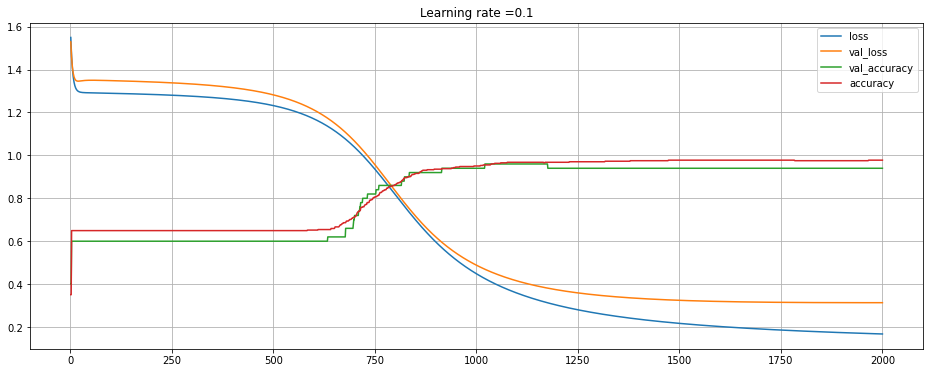

In [32]:
# %%time
nn = dlnet(20, 10, 2, 0.1)
nn.fit(X_train, y_train, n_epochs=2000, valid=(X_valid, y_valid))

In [33]:
y_proba, _ = nn.predict_proba(X_test, y_test)
pd.DataFrame(y_proba)

,0,1,2,3,4,5,6,7,8,9,...,104,105,106,107,108,109,110,111,112,113
0,0.988007,0.069109,0.100008,0.205033,0.942686,0.997777,0.995463,0.419257,0.992225,0.973255,...,0.975536,0.291240,0.293179,0.016097,0.444913,0.988544,0.005472,0.967020,0.006752,0.838896
1,0.012191,0.930019,0.899140,0.793519,0.057914,0.002274,0.004625,0.579265,0.007927,0.027100,...,0.024840,0.707627,0.705157,0.983564,0.554479,0.011669,0.994412,0.033473,0.993077,0.162415


In [34]:
y_pred = nn.predict(X_test, y_test)
pd.DataFrame(y_pred)

,0
0,0
1,1
2,1
3,1
4,0
...,...
109,0
110,1
111,0
112,1


In [35]:
print("{}: {}".format("Accuracy", ft_accuracy_score(y_test, y_pred)))

Accuracy: 0.9210526315789473


In [36]:
pd.DataFrame(y_test).T

,480,444,229,54,407,144,557,157,488,436,...,301,435,238,262,91,155,487,109,12,146
target,0,1,1,1,0,0,0,0,0,0,...,0,1,0,1,1,0,1,0,1,1


In [37]:
pd.DataFrame(y_pred).T

,0,1,2,3,4,5,6,7,8,9,...,104,105,106,107,108,109,110,111,112,113
0,0,1,1,1,0,0,0,1,0,0,...,0,1,1,1,1,0,1,0,1,0


In [46]:
confusion_matrix(y_test, y_pred)

array([[59,  5],
       [ 4, 46]], dtype=int64)

In [38]:
def plotCf(a,b,t):
    cf =confusion_matrix(a,b)
    plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
    plt.colorbar()
    plt.title(t)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    tick_marks = np.arange(len(set(a))) # length of classes
    class_labels = ['0','1']
    plt.xticks(tick_marks,class_labels)
    plt.yticks(tick_marks,class_labels)
    thresh = cf.max() / 2.
    for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
        plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
    plt.show();

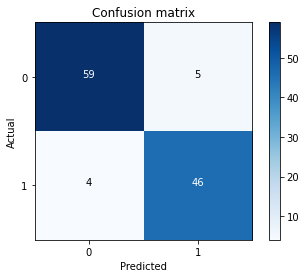

In [41]:
plotCf(y_test, y_pred, 'Confusion matrix')